# Modelling Background Data
This notebook attempts to use some basic functions and fitting algorithms to have an analytical function to describe the LHCb background data.

## Setup & Imports

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from utilities import Data, Cut, Plots, Consts

In [27]:
SFNAME, SSUFFIX = Consts().get_simulated_tuple()
RFNAME, RSUFFIX = Consts().get_real_tuple()
sd, rd = Data(SFNAME, SSUFFIX), Data(RFNAME, RSUFFIX)
sdc, rdc = Cut(sd), Cut(rd)

## Setup Plotting Functions
Plotting is a pain I just make some simple functions here so that the plots are all consistent and I do not have to repeat code what feels like 500 times.

In [40]:
def simple_hist(invariant_masses, label="Empty label", normalised=True, bins=175, figsize=(11, 9), savefig=None):
    # Create bins evenly spaced bins over the range of invariant_masses provided
    bin_space = np.linspace(int(np.round(np.min(invariant_masses), 0)), int(np.round(np.max(invariant_masses), 1)), bins+1)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    hist_data = ax.hist(invariant_masses, bins=bin_space, density=normalised, edgecolor='k', label=label)
    ax.set_ylabel(f'Frequency, normalised = {normalised}')
    ax.set_xlabel('Invariant mass (MeV)')
    plt.legend(frameon=False)
    plt.title('Histogram of Invariant Mass')
    plt.show()
    if savefig is not None:
        plt.savefig(savefig)
    return hist_data

def hist_with_errors(invariant_masses, label="Empty Label", normalised=True, bins=175, bin_space=None, figsize=(11,9), savefig=None, zoom=None):
    if bin_space is None:
        bin_space = np.linspace(int(np.round(np.min(invariant_masses), 0)), int(np.round(np.max(invariant_masses), 1)), bins+1)
    bin_centr = [(bin_space[i] + bin_space[i+1])/2 for i in range(len(bin_space) - 1)]
    bin_width = (bin_space[1] - bin_space[0])
    hist_frq_no_norm = np.histogram(invariant_masses, bin_space, density=False)
    hist_frq = np.histogram(invariant_masses, bin_space, density=normalised) # Get the normalisation factor from this
    hist_err = np.sqrt(hist_frq_no_norm[0]) # Error on the bin is proportional to the sqrt of the counts
    if normalised: # Adjust error bars to be smaller
        hist_err *= (hist_frq[0]/hist_frq_no_norm[0])
        # This will reduce the error by the normalisation factor
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.bar(bin_centr, hist_frq[0], yerr=hist_err, width=bin_width, edgecolor='k', label=label)
    if zoom is not None:
        ax.set_xlim(zoom[0], zoom[1])
    ax.set_ylabel(f'Frequency (Normalised={normalised})')
    ax.set_xlabel('Invariant Mass (MeV)')
    plt.title('Histogram of Invariant Mass')
    plt.legend(frameon=False)
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()
    return hist_frq[0], hist_err, bin_space, bin_centr

def bar_with_errs(data, bin_width, labels, figsize=(11, 9), savefig=None):
    """
    data is a list of  numpy array such that each row is a data item with the first
    column the y-position and the 2nd column the yerr and the 3rd the x
    """
    if type(data) is not list:
        data = [data]
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, dat in enumerate(data):
        ax.bar(dat[:,2], dat[:,0], yerr=dat[:,1], width=bin_width, label=labels[i], edgecolor='k')
    ax.set_xlabel('Mass (MeV)')
    ax.set_ylabel('Frequency')
    plt.legend(frameon=False)
    plt.show()
    return 0



## Fetch Data & Pre-Analyse

In [29]:
df = rd.fetch_features(['Lb_M']) 
# Get the invariant masses from the real data tuple

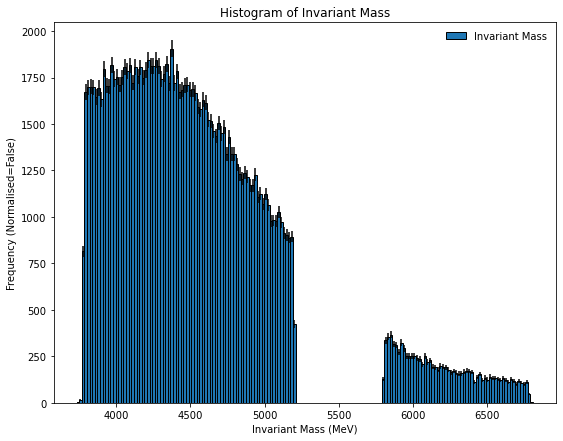

In [30]:
dat = hist_with_errors(df, label='Invariant Mass', figsize=(9, 7), normalised=False)

In [31]:
frequencies, errors, spacings, centres = dat
# Split out the dat tuple to the appropriate variables

Apply a basic masscut to remove the rubbish data at the extremes which for now we arbitraruly define as our region of interest $\pm800$ MeV. But first combine the calculated frequencies and errors into an array.

In [32]:
data_with_errs = np.array([frequencies, errors, centres]).T
# Combine the data into a big array for ease in the next bit of code
roi = [4400, 6600]
# Define the region of interest, this is arbitrarily set by me currently
data_with_errs = data_with_errs[data_with_errs[:,2] >= 4400, :]
data_with_errs = data_with_errs[data_with_errs[:,2] <= 6600, :]
bin_width = spacings[1] - spacings[0]

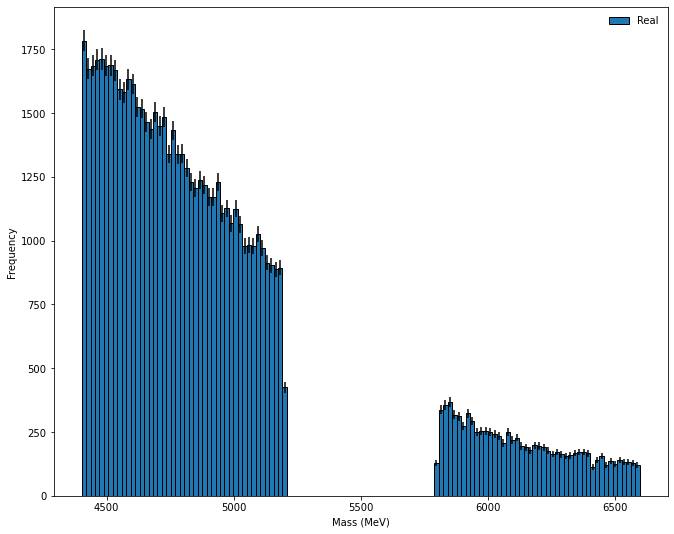

0

In [41]:
bar_with_errs(data_with_errs, bin_width=bin_width, labels=['Real'])

## Rejigging The Plot
Now we have cut the extremes of the data (which is not well reproduced by the simulation) we can try and fit a function to just this data and see how it fairs. We will use a variety of fitting algorithms starting with the simplest, the least-squares fitting routine. We also will zoom-in on the area of interest whilst using the same bin space.

In [34]:
# Find the start and ends of the bins where there is actually data so we can set an appropriate x-lim
first_non_zero = (first_cut_hist[0] != 0).argmax(axis=0) - 1 
# Apply a mask where all zeros are False and rest is true
last_non_zero = first_cut_hist[0].shape[0] - (np.flip((first_cut_hist[0]!=0)).argmax(axis=0) - 1)
# Reverse the array, find the first occurence and subtract from the length of the array
lower_plot_lim, upper_plot_lim = first_cut_hist[2][first_non_zero-1], first_cut_hist[2][last_non_zero+1]
# The actual energies are the indices from the bin-space, given by b[2]

NameError: name 'first_cut_hist' is not defined

/tmp/ipykernel_2494370/1828583453.py:24: RuntimeWarning: invalid value encountered in true_divide
  hist_err *= (hist_frq[0]/hist_frq_no_norm[0])


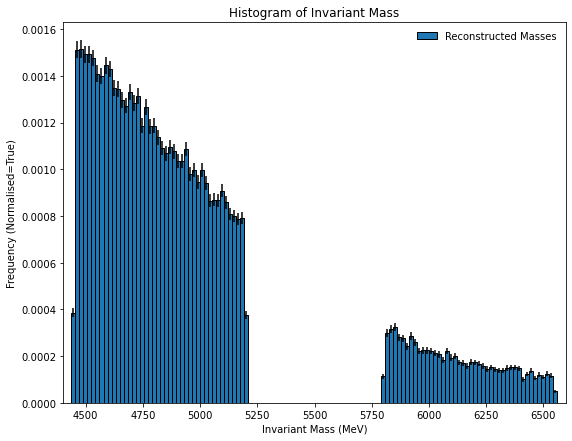

In [ ]:
first_cut_hist = hist_with_errors(cdf, label='Reconstructed Masses', bin_space=dat[2], zoom=(lower_plot_lim, upper_plot_lim), figsize=(9, 7))

Prepare these data for being fit to by removing all the zero bins and associated errors etc across all the arrays.

In [ ]:
# Combine frequencies, bin centroids and errors into one big array to make removing empty bins easier!
bin_width = first_cut_hist[2][1] - first_cut_hist[2][0]
data = np.array([first_cut_hist[0], first_cut_hist[1], first_cut_hist[3]]).T
# Data is made of 3 columns the frequencies, errors and then the bin centroid, remove all ros with freq=0
data = np.squeeze(data[np.where(data[:,0] != 0),:]) # Find all rows where the first column is not zero and keeps them
# Using numpy.squeeze as other shape returned is (50, 3, 1), removes the redundant axis

## Define Functions
Now we define some functions that we will attempt to fit to these data using a range of fitting routines starting with a least-squares.

In [ ]:
def exponential(x, A, B, C):
    """
    A simple exponential function with a shift of B and amplitude A
    """
    return (A*np.exp(-(x+B)))+C

def gaussian(x, mu, sigma):
    """
    A standard Gaussian distribution (not normalised)
    """
    return (1/(np.sqrt(2*np.pi)*sigma))*np.exp((x-mu)**2/(2*(sigma**2)))

def power(x, A, B, C, D):
    """
    A simple power law function of the form A(x-B)^C
    """
    return A*(x-B)**(C) + D

def logarithmic(x, A, B, C):
    """
    A logarithm-like function of the form f(x)=-Bln((x-A)) + C
    """
    return -(B * np.log(x-A)) + C

/tmp/ipykernel_2494370/1955373763.py:23: RuntimeWarning: invalid value encountered in log
  return -(B * np.log(x-A)) + C


[ 3434.87218216  1311.25827559 10596.15388163]


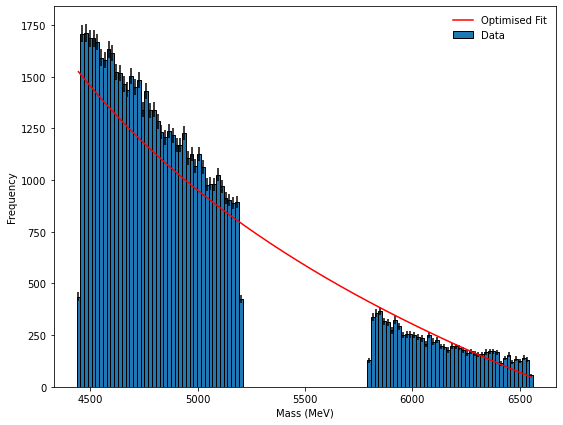

In [ ]:
# Now we fit the above
from scipy.optimize import curve_fit 

# Use the most basic of fitting routines first
popt, pcov = curve_fit(exponential, data[:,2], data[:,0], p0=[1, 1, 1], sigma=data[:,1])
print(popt)
# power: -1, 0, 0.5, 1e+3
# Logarithmic: [ 3434.87218216  1311.25827559 10596.15388163]

func_plot_range = np.linspace(np.min(data[:,2]), np.max(data[:,2]), 500)
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.bar(data[:,2], data[:,0], yerr=data[:,1], edgecolor='k', width=bin_width, label='Data')
ax.plot(func_plot_range, exponential(func_plot_range, *popt), label='Optimised Fit', c='r')
ax.set_ylabel('Frequency')
ax.set_xlabel('Mass (MeV)')
plt.legend(frameon=False)
plt.show()